In [2]:
!pip install wordcloud


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/301.4 kB ? eta -:--:--
   ------------------------------------ --- 276.5/301.4 kB 8.3 MB/s eta 0:00:01
   ---------------------------------------- 301.4/301.4 kB 6.2 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# For Text processing 
import nltk
import re
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score as acscore, classification_report as cr, confusion_matrix as cm

In [ ]:

# Load and Check Dataset


In [4]:
df = pd.read_csv("spam_ham_dataset.csv")

In [ ]:
# EDA

In [5]:
# First 5 rows of Dataset
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [13]:
df.describe()


,Unnamed: 0,label_num
count,5171.000000,5171.000000
mean,2585.000000,0.289886
std,1492.883452,0.453753
min,0.000000,0.000000
25%,1292.500000,0.000000
50%,2585.000000,0.000000
75%,3877.500000,1.000000
max,5170.000000,1.000000


In [ ]:

# Data Preprocessing


In [8]:
df.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df["label"].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

In [14]:
# Data in the label_num column

In [15]:
ham_count = df.loc[df['label'] == 'ham', 'label_num'].count()
print(ham_count)

3672


In [16]:
spam_count = df.loc[df['label'] == 'spam', 'label_num'].count()
print(spam_count)


1499


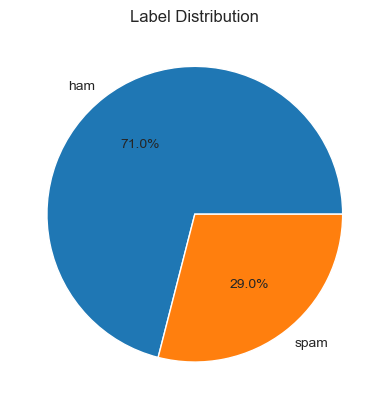

In [17]:
label_counts = df['label'].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Label Distribution')
plt.show()

In [18]:
#Drop unnecessary columns or feature
df = df.drop(columns=["Unnamed: 0", "label"])

In [21]:
df = df.reset_index(drop=True)

In [22]:
# Shape of the dataframe
df.shape

(5171, 2)

In [25]:
df.head()

,text,label_num
0,Subject : enron methanol ; meter # : 988291 fo...,0
1,"Subject : hpl nom january 9 , 2001 ( see attac...",0
2,"Subject : neon retreat ho ho ho , ' around won...",0
3,"Subject : photoshop , windows , office . cheap...",1
4,Subject : : indian springs deal book teco pvr ...,0


In [23]:
#  Text Preprocessing

In [24]:
%%time
stop_words = set(stopwords.words('english')) 

df['text'] = df['text'].apply(lambda x: ' '.join([ word for word in word_tokenize(x)  if not word in stop_words]))

CPU times: total: 4.23 s
Wall time: 4.3 s


In [26]:
# Function to clean and preprocess text
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    
    # Join the stemmed tokens back into a single string
    preprocessed_text = ' '.join(stemmed_tokens)
    
    return preprocessed_text

In [27]:
# Apply the preprocess_text function to the 'text' column
df['text'] = df['text'].apply(preprocess_text)

# Print the cleaned text
print(df['text'])

0       subject enron methanol meter follow note gave ...
1       subject hpl nom januari see attach file hplnol...
2       subject neon retreat ho ho ho around wonder ti...
3       subject photoshop window offic cheap main tren...
4       subject indian spring deal book teco pvr reven...
                              ...                        
5166    subject put ft transport volum decreas contrac...
5167    subject follow nom hpl take extra mmcf weekend...
5168    subject calpin daili ga nomin juli mention ear...
5169    subject industri worksheet august activ attach...
5170    subject import onlin bank alert dear valu citi...
Name: text, Length: 5171, dtype: object


In [28]:
df.head()

,text,label_num
0,subject enron methanol meter follow note gave ...,0
1,subject hpl nom januari see attach file hplnol...,0
2,subject neon retreat ho ho ho around wonder ti...,0
3,subject photoshop window offic cheap main tren...,1
4,subject indian spring deal book teco pvr reven...,0


In [29]:
X = df.loc[:, 'text']
y = df.loc[:, 'label_num']
print(f"Shape of X: {X.shape}\nshape of y: {y.shape}")

Shape of X: (5171,)
shape of y: (5171,)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [31]:
print(f"Train Data Shape: {X_train.shape}\nTest Data Shape: {X_test.shape}")

Train Data Shape: (4136,)
Test Data Shape: (1035,)


In [33]:

# Count Vectorizer


In [34]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [35]:
X_train = X_train.toarray()

In [38]:
LR = LogisticRegression()
LR.fit(X_train,y_train)

LogisticRegression()

In [39]:
# Prediction of the model on training data and their outcomes: -


accuracy_score of train data 0.999274661508704 



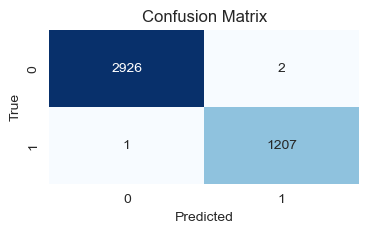

classification_report of train data
 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2928
           1       1.00      1.00      1.00      1208

    accuracy                           1.00      4136
   macro avg       1.00      1.00      1.00      4136
weighted avg       1.00      1.00      1.00      4136



In [40]:
y_pred = LR.predict(X_train)

LR_accuracy_train = acscore(y_train,y_pred)
print("accuracy_score of train data", LR_accuracy_train,"\n")

cmm = cm(y_train,y_pred)
plt.figure(figsize=(4, 2))
sns.heatmap(cmm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

classification_report = cr(y_train,y_pred)
print("classification_report of train data\n","\n", classification_report)

In [41]:
# Prediction of the model on test data and their outcomes: -

accuracy_score of test data 0.978743961352657 



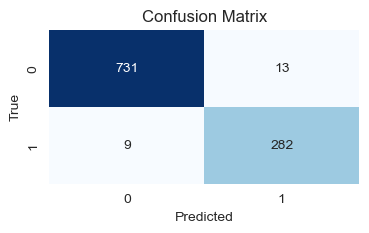

classification_report of test data
 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       744
           1       0.96      0.97      0.96       291

    accuracy                           0.98      1035
   macro avg       0.97      0.98      0.97      1035
weighted avg       0.98      0.98      0.98      1035



In [42]:
y_prred = LR.predict(X_test)

LR_accuracy_test = acscore(y_test,y_prred)
print("accuracy_score of test data", LR_accuracy_test,"\n")

cmm = cm(y_test, y_prred)
plt.figure(figsize=(4, 2))
sns.heatmap(cmm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

classification_report = cr(y_test,y_prred)
print("classification_report of test data\n","\n", classification_report)

In [43]:
# Prediction of the model on training data and their outcomes: -


In [45]:
RFC = RandomForestClassifier(n_estimators = 100, random_state = 42)
RFC.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

accuracy_score of train data 1.0 



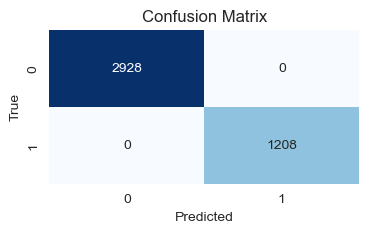

classification_report of train data
 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2928
           1       1.00      1.00      1.00      1208

    accuracy                           1.00      4136
   macro avg       1.00      1.00      1.00      4136
weighted avg       1.00      1.00      1.00      4136



In [46]:
y_predd = RFC.predict(X_train)

RFC_accuracy_train = acscore(y_train,y_predd)
print("accuracy_score of train data", RFC_accuracy_train,"\n")

cmm = cm(y_train, y_predd)
plt.figure(figsize=(4, 2))
sns.heatmap(cmm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

classification_report = cr(y_train,y_predd)
print("classification_report of train data\n","\n", classification_report)

In [47]:
# Prediction of the model on test data and their outcomes: -

accuracy_score of test data 0.9729468599033816 



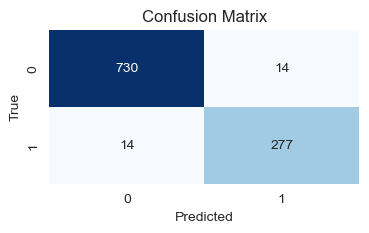

classification_report of test data
 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       744
           1       0.95      0.95      0.95       291

    accuracy                           0.97      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



In [48]:
y_preed = RFC.predict(X_test)

RFC_test_accuracy = acscore(y_test,y_preed)
print("accuracy_score of test data", RFC_test_accuracy,"\n")

cmm = cm(y_test, y_preed)
plt.figure(figsize=(4, 2))
sns.heatmap(cmm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

classification_report = cr(y_test,y_preed)
print("classification_report of test data\n","\n", classification_report)

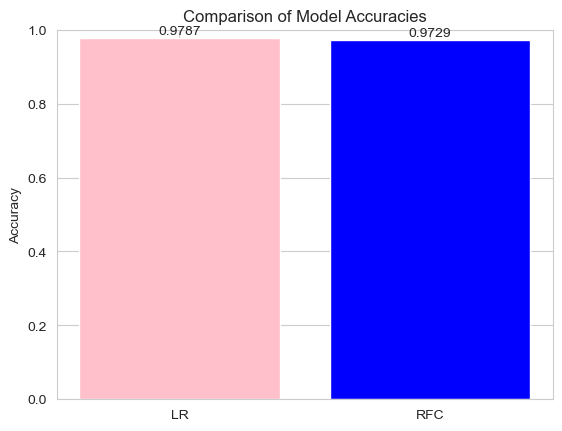

In [51]:
models = ['LR','RFC']
accuracies = [LR_accuracy_test, RFC_test_accuracy]

# Plotting the bar chart
fig, ax = plt.subplots()
bars = ax.bar(models, accuracies, color=['pink','blue'])

# Adding the accuracy values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.ylim([0, 1])  
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.show()


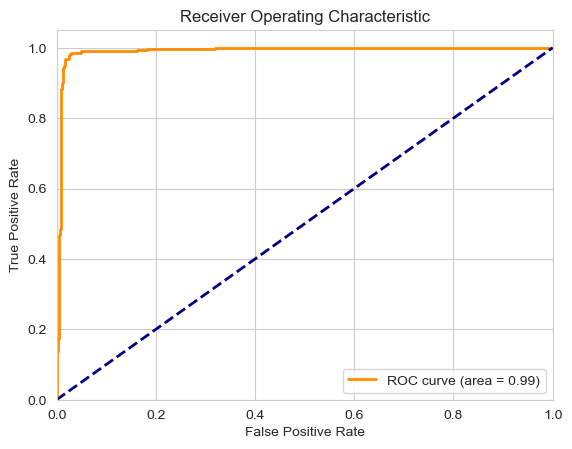

In [52]:
y_scores = LR.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()